In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.regularizers import l1
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

#**PART 1: DATA ANALYSIS FOR TRAINING**

###READING THE DATA FROM THE DRIVE

In [4]:
columns = ['unit_no', 'cycles', 'oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train = pd.read_csv(("drive/My Drive/Final Data/Challenge_Data - Aerostrovilos/train.txt"), sep ='\s+', header=None, names = columns)
# df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD003.txt"), sep ='\s+', header=None, names = columns)
# df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD003.txt"), sep ='\s+', header=None, names = ['RUL'])

In [5]:
df_train[0:5]

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [6]:
df_train.isnull().sum()

unit_no    0
cycles     0
oc_1       0
oc_2       0
oc_3       0
s_1        0
s_2        0
s_3        0
s_4        0
s_5        0
s_6        0
s_7        0
s_8        0
s_9        0
s_10       0
s_11       0
s_12       0
s_13       0
s_14       0
s_15       0
s_16       0
s_17       0
s_18       0
s_19       0
s_20       0
s_21       0
dtype: int64

###*Hence, we see that the data is clean, has no NaN, nor does it have any blank cells.*



###The below line of code finds the maximum number of cycles each unit of engine takes until failure. This will be useful to make the "Remaining Useful Life" column

In [7]:
max_cycles_train = df_train.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'})

###In the below cell, we are adding 2 new columns to the Dataframe, namely "MaxCycleID" and "RUL". "MaxCycleID" is the total number of cycles the unit took to fail. Then we subtract the number of cycles that have been performed, from the total number of cycles the unit took to fail.This gives the Remaining Useful Life, which is stored in the column "RUL".

In [8]:
df_train = pd.merge(df_train, max_cycles_train, how='inner', on='unit_no')
df_train['RUL'] = df_train['MaxCycleID'] - df_train['cycles']
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


In [9]:
print(np.max(np.array(df_train['MaxCycleID'])))

357


###Now we delete the column "MaxCycleID", since we have found the RUL.

In [10]:
df_train = df_train.drop(labels='MaxCycleID', axis=1)
df_train

,unit_no,cycles,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,1


###IN THE BELOW CELL, WE ARE SAVING THE COLUMN FOR REMIANING USEFUL LIFE IN THE VARIABLE 'RUL'. THEN WE CONVERT THIS ARRAY INTO A DATAFRAME AND SAVE IT IN THE VARIABLE "df_train_y_final" FOR FUTURE USE. WE THEN SAVE THE COLUMNS "cycles", & "unit_no" IN THE VARIABLES "cycles" & "unit". NOW WE DROP THESE COLUMNS, TO GET THE DATASET WITH ONLY OPERATIONAL CONDITIONS AND SENSOR READINGS, i.e. THE DATA POINTS THAT MAY PLAY A ROLE IN PREDICTION.

In [11]:
unit= df_train['unit_no'].values
unit = unit[~np.isnan(unit)]
L= len(unit)
RUL= df_train['RUL'].values
RUL= RUL[~np.isnan(RUL)]

################################################################
df_train_y_final = pd.DataFrame(RUL)
################################################################

cycles = df_train['cycles'].values
df_train_temp = df_train.drop(labels={'RUL','unit_no','cycles'}, axis=1)
df_train_temp

,oc_1,oc_2,oc_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


###BEFORE THE BELOW SCALING, WE NEED TO FIND CLUSTERS AND THEN SCALE WITHIN THE CLUSTERS

###################################################################################

In [12]:
OpConditionData = df_train_temp[['oc_1','oc_3','oc_3']]
OpConditionData

,oc_1,oc_3,oc_3
0,10.0047,20.0,20.0
1,0.0015,100.0,100.0
2,34.9986,60.0,60.0
3,20.0031,0.0,0.0
4,42.0041,40.0,40.0
...,...,...,...
45913,42.0066,40.0,40.0
45914,42.0029,40.0,40.0
45915,41.9999,40.0,40.0
45916,35.0007,60.0,60.0


Cluster 1 Inertia 107070571.76736699
Cluster 2 Inertia 34410931.26043652
Cluster 3 Inertia 11656627.038067702
Cluster 4 Inertia 6163216.049687007
Cluster 5 Inertia 3071721.1771970303
Cluster 6 Inertia 0.33231808458003476
Cluster 7 Inertia 0.259318326617995
Cluster 8 Inertia 0.2156968607076085
Cluster 9 Inertia 0.1732963728857973
Cluster 10 Inertia 0.1307877326744836
Cluster 11 Inertia 0.08935125408799985
Cluster 12 Inertia 0.0745317772632592
Cluster 13 Inertia 0.06860280403727179
Cluster 14 Inertia 0.05885395416565398
Cluster 15 Inertia 0.050537565816140904
Cluster 16 Inertia 0.04577014376199328
Cluster 17 Inertia 0.03733215071884238
Cluster 18 Inertia 0.0335447795910078
Cluster 19 Inertia 0.03105385071322024


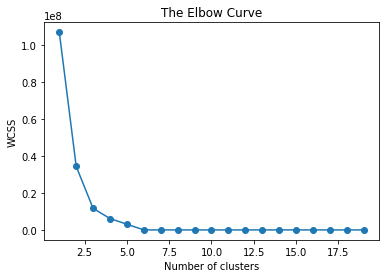

In [13]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=500,n_init=10,random_state=0)
    kmeans.fit(OpConditionData)
    wcss.append(kmeans.inertia_)
    print("Cluster", i, "Inertia", kmeans.inertia_)
plt.scatter(range(1,20),wcss)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
plt.show()

In [14]:
kmean=KMeans(n_clusters=6)
kmean.fit(OpConditionData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

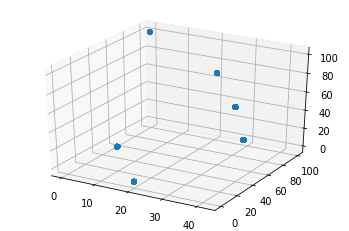

In [15]:
ax = plt.axes(projection='3d')
OpConditionData1 = np.array(OpConditionData)
# Data for three-dimensional scattered points
xdata = OpConditionData1[:,0]
ydata = OpConditionData1[:,1]
zdata = OpConditionData1[:,2]
ax.scatter3D(xdata, ydata, zdata,  cmap='Blues');#c=zdata, cmap='Blues');

In [16]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = OpConditionData.index.values
cluster_map['cluster'] = kmean.labels_

cluster0 = cluster_map[cluster_map.cluster == 0]
cluster0_index = np.array(cluster0[['data_index']])
cluster0_index = cluster0_index.reshape((len(cluster0_index),))

cluster1 = cluster_map[cluster_map.cluster == 1]
cluster1_index = np.array(cluster1[['data_index']])
cluster1_index = cluster1_index.reshape((len(cluster1_index),))

cluster2 = cluster_map[cluster_map.cluster == 2]
cluster2_index = np.array(cluster2[['data_index']])
cluster2_index = cluster2_index.reshape((len(cluster2_index),))

cluster3 = cluster_map[cluster_map.cluster == 3]
cluster3_index = np.array(cluster3[['data_index']])
cluster3_index = cluster3_index.reshape((len(cluster3_index),))

cluster4 = cluster_map[cluster_map.cluster == 4]
cluster4_index = np.array(cluster4[['data_index']])
cluster4_index = cluster4_index.reshape((len(cluster4_index),))

cluster5 = cluster_map[cluster_map.cluster == 5]
cluster5_index = np.array(cluster5[['data_index']])
cluster5_index = cluster5_index.reshape((len(cluster5_index),))

In [17]:
df_train_temp['Cluster_Index'] = np.nan
df_train_temp_array = np.array(df_train_temp)
df_train_temp_array[cluster0_index, 24] = 0
df_train_temp_array[cluster1_index, 24] = 1
df_train_temp_array[cluster2_index, 24] = 2
df_train_temp_array[cluster3_index, 24] = 3
df_train_temp_array[cluster4_index, 24] = 4
df_train_temp_array[cluster5_index, 24] = 5
df_train_temp2 = pd.DataFrame(df_train_temp_array)
df_train_temp2.columns =['oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21','Cluster_Index'] 
df_train_temp2 = df_train_temp2.drop(labels='oc_1', axis=1)
df_train_temp2 = df_train_temp2.drop(labels='oc_2', axis=1)
df_train_temp2 = df_train_temp2.drop(labels='oc_3', axis=1)
df_train_temp2.insert(0, column='Sl_No', value=range(45918))
df_train_temp2

,Sl_No,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,Cluster_Index
0,0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368.0,2319.0,100.00,28.58,17.1735,0.0
1,1,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391.0,2388.0,100.00,38.99,23.3619,1.0
2,2,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334.0,2223.0,100.00,14.83,8.8555,5.0
3,3,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364.0,2324.0,100.00,24.42,14.7832,4.0
4,4,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330.0,2212.0,100.00,10.99,6.4025,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,45913,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333.0,2212.0,100.00,10.57,6.2985,2.0
45914,45914,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332.0,2212.0,100.00,10.40,6.2741,2.0
45915,45915,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334.0,2212.0,100.00,10.37,6.1978,2.0
45916,45916,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337.0,2223.0,100.00,14.70,8.6761,5.0


In [18]:
cluster_0 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 0]
cluster_1 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 1]
cluster_2 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 2]
cluster_3 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 3]
cluster_4 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 4]
cluster_5 = df_train_temp2.loc[df_train_temp2['Cluster_Index'] == 5]

In [19]:
sl0 = cluster_0['Sl_No'].values
cluster_0_final = cluster_0.drop(['Sl_No','Cluster_Index'], axis=1)

sl1 = cluster_1['Sl_No'].values
cluster_1_final = cluster_1.drop(['Sl_No','Cluster_Index'], axis=1)

sl2 = cluster_2['Sl_No'].values
cluster_2_final = cluster_2.drop(['Sl_No','Cluster_Index'], axis=1)

sl3 = cluster_3['Sl_No'].values
cluster_3_final = cluster_3.drop(['Sl_No','Cluster_Index'], axis=1)

sl4 = cluster_4['Sl_No'].values
cluster_4_final = cluster_4.drop(['Sl_No','Cluster_Index'], axis=1)

sl5 = cluster_5['Sl_No'].values
cluster_5_final = cluster_5.drop(['Sl_No','Cluster_Index'], axis=1)


In [20]:
sc = StandardScaler()
cluster_0_scaled = pd.DataFrame(sc.fit_transform(cluster_0_final))
cluster_1_scaled = pd.DataFrame(sc.fit_transform(cluster_1_final))
cluster_2_scaled = pd.DataFrame(sc.fit_transform(cluster_2_final))
cluster_3_scaled = pd.DataFrame(sc.fit_transform(cluster_3_final))
cluster_4_scaled = pd.DataFrame(sc.fit_transform(cluster_4_final))
cluster_5_scaled = pd.DataFrame(sc.fit_transform(cluster_5_final))

cluster_0_scaled.insert(0, column='Sl_No', value=sl0)
cluster_1_scaled.insert(0, column='Sl_No', value=sl1)
cluster_2_scaled.insert(0, column='Sl_No', value=sl2)
cluster_3_scaled.insert(0, column='Sl_No', value=sl3)
cluster_4_scaled.insert(0, column='Sl_No', value=sl4)
cluster_5_scaled.insert(0, column='Sl_No', value=sl5)


In [21]:
data_train_regime_scaled = pd.concat([cluster_0_scaled,cluster_1_scaled,cluster_2_scaled,cluster_3_scaled,cluster_4_scaled,cluster_5_scaled],ignore_index=True)
data_train_scaled = data_train_regime_scaled.sort_values(by=['Sl_No'], inplace=False, ignore_index=True)
df_train_scaled = data_train_scaled.drop(labels='Sl_No', axis=1)
df_train_scaled.columns =['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train_scaled.insert(0, "unit_no", unit, True) 
df_train_scaled.insert(1, "cycles", cycles, True) 
df_train_scaled

,unit_no,cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-1.0,-1.665753,-0.460783,-0.168939,1.0,-0.699491,0.854771,-0.979801,-0.778629,0.000000,-0.381680,1.356156,-0.360239,-0.822727,-1.170346,-1.000000,-1.181068,0.0,0.0,0.377665,0.675931
1,1,2,0.0,-1.201516,-1.040896,-0.626351,-1.0,0.117058,0.423962,-1.379941,-0.837893,-1.000000,-1.033360,0.637742,0.652784,-0.472053,-1.468435,-1.000000,-1.520270,0.0,0.0,1.036586,0.735222
2,1,3,1.0,-0.920644,0.218754,-1.283286,-1.0,-0.173751,1.060740,-0.561708,-0.646329,-0.178589,-0.335437,0.668924,-0.545028,-0.461180,0.550787,1.000000,-0.205357,0.0,0.0,0.022285,-0.595899
3,1,4,1.0,-1.212695,0.422400,-0.577347,1.0,-1.476105,0.608401,-1.335809,-0.431145,0.555343,-0.877883,-0.016307,-0.651581,-0.817109,-0.314208,-0.548739,-1.005757,0.0,0.0,-0.202160,1.411696
4,1,5,0.0,-0.456473,-0.034710,-0.513983,1.0,-1.173020,-0.856431,-0.500077,-0.689584,-0.148603,-1.595495,-0.271850,-0.429287,-0.286506,-2.132402,0.000000,-0.793951,0.0,0.0,3.771267,0.808197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,0.0,2.960030,1.870192,2.545515,1.0,0.852501,-1.466383,-2.057484,-1.317894,-0.148603,2.202003,-0.943040,-1.964938,-1.536489,2.439832,0.000000,1.334596,0.0,0.0,-0.126274,-0.823102
45914,218,130,0.0,0.796245,1.919624,1.854447,1.0,-1.173020,-2.392605,-2.190029,-1.346102,-0.148603,1.945992,-0.855494,-2.302782,-1.585767,2.296103,0.000000,0.625080,0.0,0.0,-1.703850,-1.205829
45915,218,131,0.0,0.454595,0.800340,2.905611,1.0,0.852501,-1.285657,-2.355710,-0.974426,-0.148603,2.842031,-1.964416,-2.149217,-1.544902,2.860174,0.000000,2.044111,0.0,0.0,-1.982245,-2.402638
45916,218,132,1.0,1.651665,2.319687,1.833978,-1.0,-0.173751,0.344959,-1.693518,-1.414847,-0.178589,2.669020,-2.580569,-1.831100,-1.785693,2.268910,1.000000,1.943998,0.0,0.0,-1.133010,-3.193441


In [22]:
# mean0 = cluster_0.mean(axis=0)
# std0 = cluster_0.std(axis=0)
# mean1 = cluster_1.mean(axis=0)
# std1 = cluster_1.std(axis=0)
# mean2 = cluster_2.mean(axis=0)
# std2 = cluster_2.std(axis=0)
# mean3 = cluster_3.mean(axis=0)
# std3 = cluster_3.std(axis=0)
# mean4 = cluster_4.mean(axis=0)
# std4 = cluster_4.std(axis=0)
# mean5 = cluster_5.mean(axis=0)
# std5 = cluster_5.std(axis=0)

** #####################################################################################**

###IN THE BELOW CELL, WE USE THE LIBRARY FUNCTION, "StandardScaler" TO SCALE AND NORMALIZE THE DATA. THEN WE INSERT THE COLUMNS "unit_no" AND "cycles" BACK INTO THE DATAFRAME FOR PLOTTING. WE SAVE THE SCALED DATASET IN THE VARIABLE "df_train_scaled".

In [23]:
# #@title Default title text
# sc = StandardScaler()
# df_train_temp = sc.fit_transform(df_train_temp)
# df_train_temp = pd.DataFrame(df_train_temp)
# df_train_temp
# df_train_temp.columns =['oc_1', 'oc_2', 'oc_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9','s_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21'] 
# df_train_temp.insert(0, "unit_no", unit, True) 
# df_train_temp.insert(1, "cycles", cycles, True) 

# df_train_scaled = df_train_temp

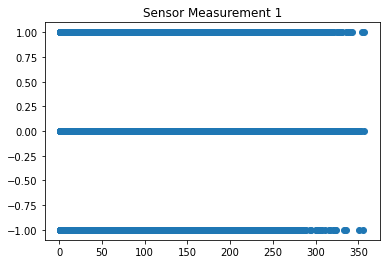

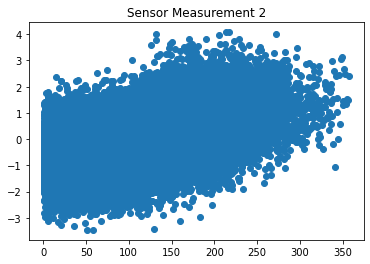

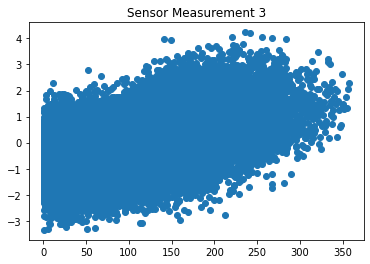

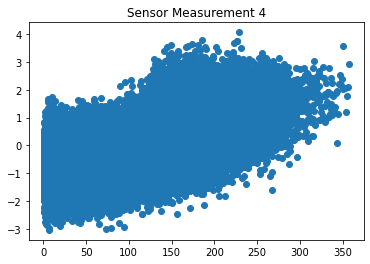

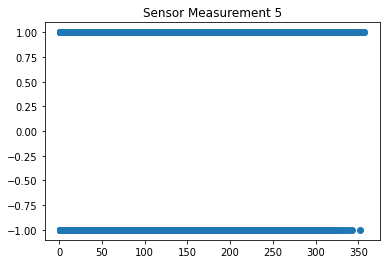

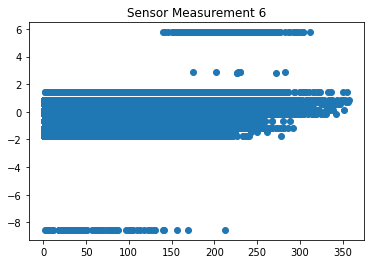

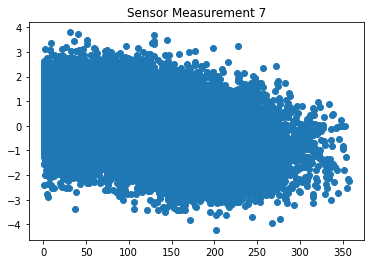

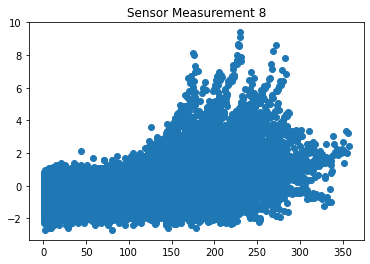

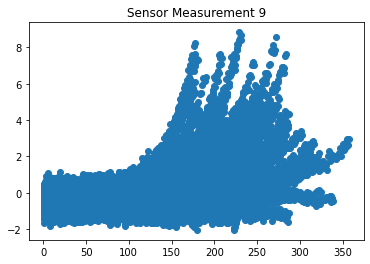

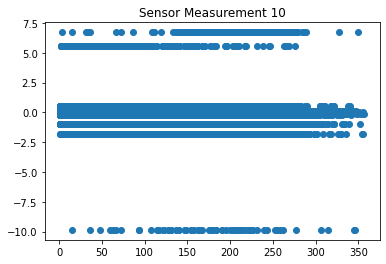

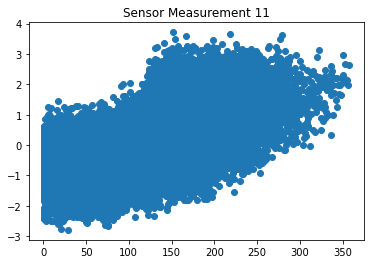

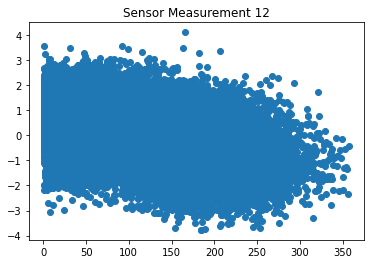

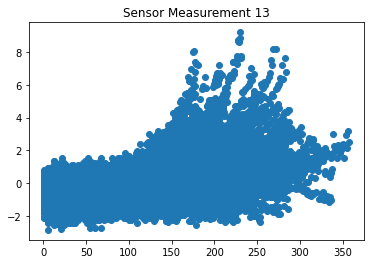

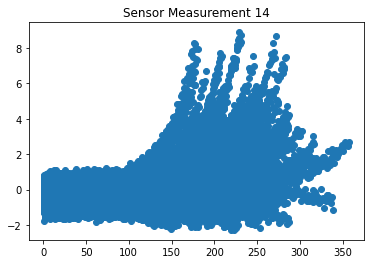

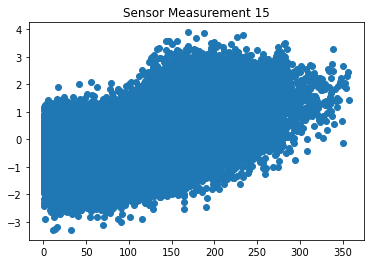

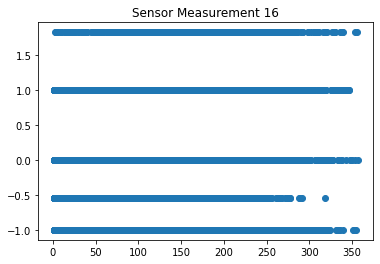

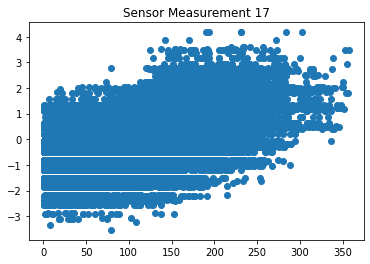

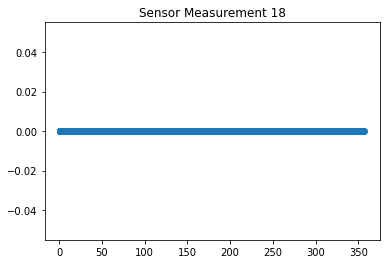

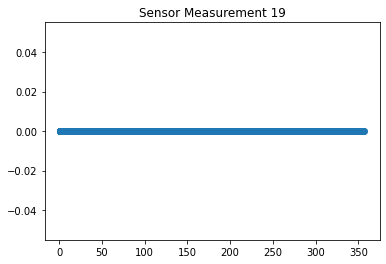

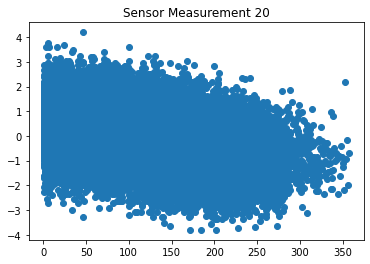

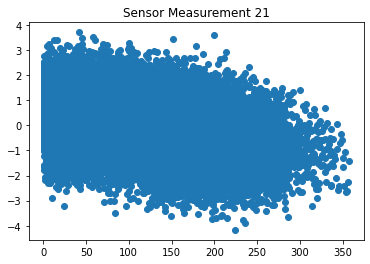

In [24]:
for i in range(1,22):
    plt.figure()
    temp= df_train_scaled['s_'+str(i)].values
    temp= temp[~np.isnan(temp)]
    plt.scatter(cycles,temp)
    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)
# for i in range(1,4):
#     plt.figure()
#     temp= df_train_scaled['oc_'+str(i)].values
#     plt.scatter(cycles,temp)
#     plt.title('Operational Condition '+str(i))
#     plt.show(block= False)

### FROM THE ABOVE PLOTS WE SEE THAT READINGS FROM SENSORS 1, 5, 16, 18 & 19 REMAIN CONSTANT ALWAYS AND SO CAN BE DROPPED WHILE TRAINING THE MODEL.

In [25]:
from random import randrange
p = np.zeros(5)
for i in range(5):
    p[i] = randrange(219)
print(p)

[ 52.  26.  29.  93. 217.]


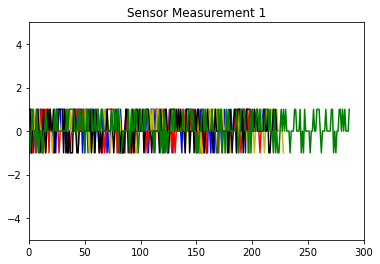

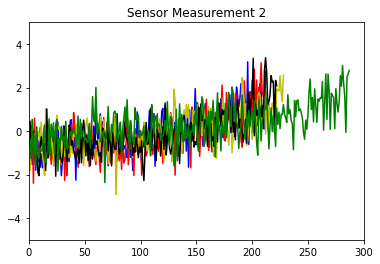

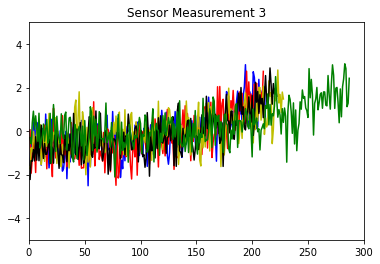

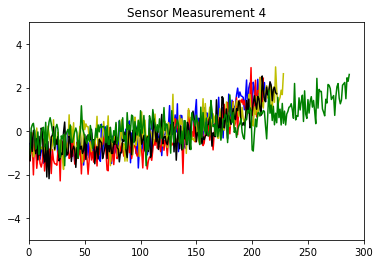

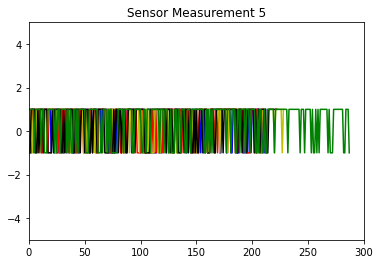

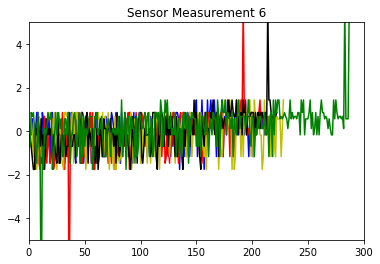

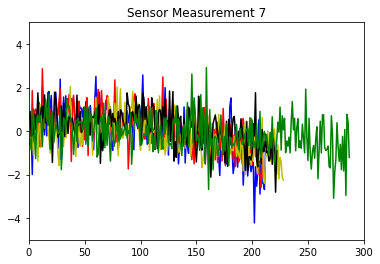

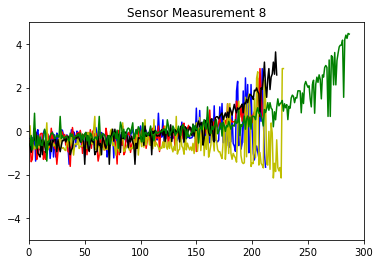

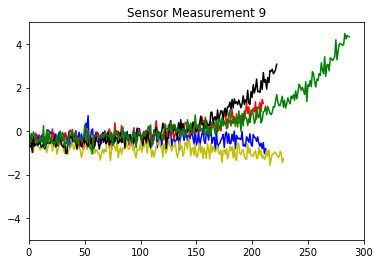

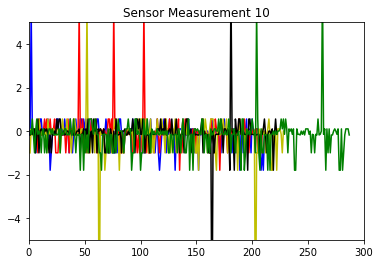

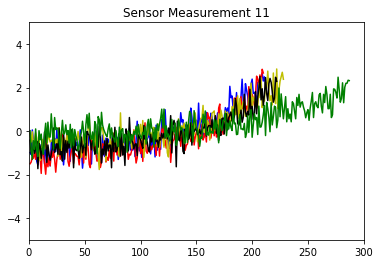

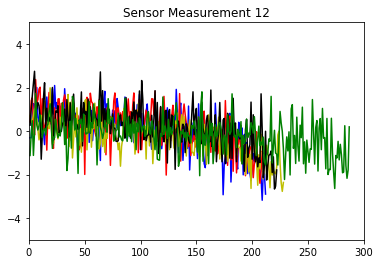

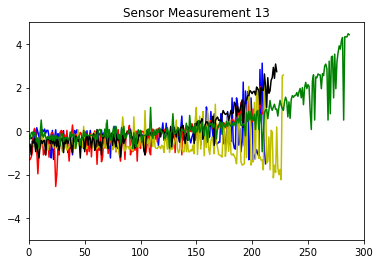

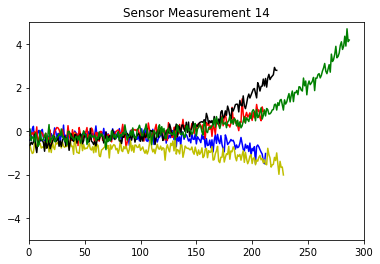

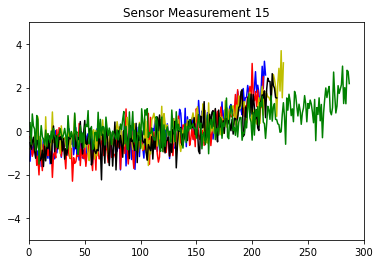

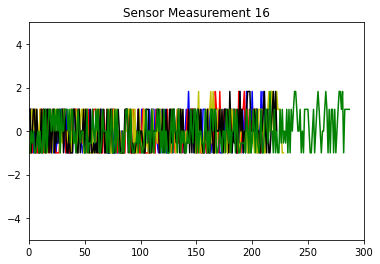

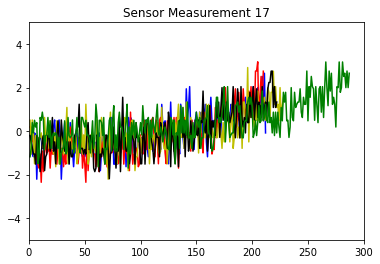

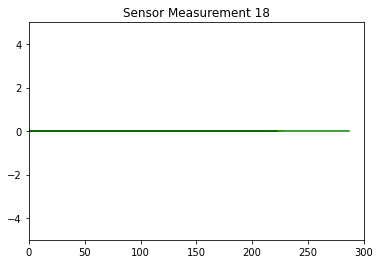

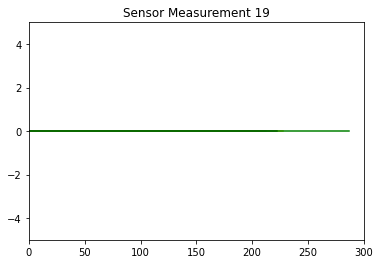

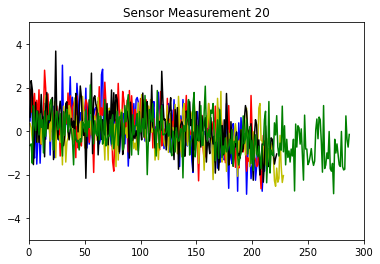

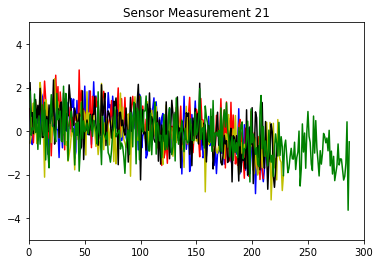

In [26]:
for i in range(1,22):
    plt.figure()
    for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
        data_unit = df_train_scaled[df_train['unit_no'] == j] 
        cycles_unit = data_unit['cycles'].values
        temp= data_unit['s_'+str(i)].values
        temp= temp[~np.isnan(temp)]
        plt.plot(cycles_unit,temp, c = col)
        plt.ylim([-5,5])
        plt.xlim([0,300])

    plt.title('Sensor Measurement '+str(i))
    plt.show(block= False)
# for i in range(1,4):
#     plt.figure()
#     for j,col in [[p[0],'b'],[p[1],'r'],[p[2],'y'],[p[3],'black'],[p[4],'g']]:
#         data_unit = df_train_scaled[df_train['unit_no'] == j] 
#         cycles_unit = data_unit['cycles'].values
#         temp= data_unit['oc_'+str(i)].values
#         temp= temp[~np.isnan(temp)]
#         plt.plot(cycles_unit,temp, c = col)
#         plt.ylim([-5,5])
#         plt.xlim([0,300])
#     plt.title('Operational Condition '+str(i))
#     plt.show(block= False)


In [27]:
S= np.ndarray(shape=(L,0))
sen = [2,3,4,7,11,12, 15,17]

num_sen= len(sen)
for i in sen:
    temp= df_train_scaled['s_' + str(i)].values
    temp = temp[~np.isnan(temp)].reshape(L, 1)
    S= np.hstack((S,temp))

In [28]:
df_train_x_final = pd.DataFrame(S)
df_train_x_final.columns =['s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17'] 
df_train_x_final.insert(0, "unit_no", unit, True) 
df_train_x_final.insert(1, "cycles", cycles, True)
####################################################################################################
df_train_x_final
####################################################################################################

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1,1,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,1,2,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,1,3,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,1,4,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,1,5,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...,...,...
45913,218,129,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,218,130,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,218,131,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,218,132,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


Text(0, 0.5, 'Cumulative explained variance')

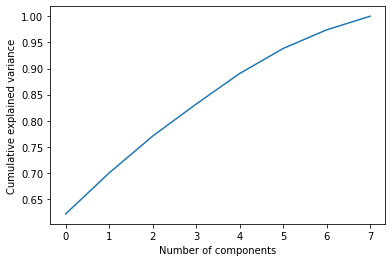

In [29]:
df_train_x_forPCA = df_train_x_final.drop(["unit_no","cycles"],axis=1)
pca = PCA(n_components=8)
pca.fit(df_train_x_forPCA)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [30]:
df_train_x_final.to_csv("drive/My Drive/Final Data/Challenge_Data - Aerostrovilos/train_x_trended.csv",index=False)
df_train_y_final.to_csv("drive/My Drive/Final Data/Challenge_Data - Aerostrovilos/train_y_trended.csv",index=False)

In [40]:
df_train_x_final = pd.DataFrame(df_train_x_final)
df_train_x_final.columns =['unit_no', 'cycles','s_2', 's_3', 's_4', 's_7','s_11', 's_12', 's_15', 's_17'] 
df_train_x_final

,unit_no,cycles,s_2,s_3,s_4,s_7,s_11,s_12,s_15,s_17
0,1.0,1.0,-1.665753,-0.460783,-0.168939,0.854771,-0.381680,1.356156,-1.170346,-1.181068
1,1.0,2.0,-1.201516,-1.040896,-0.626351,0.423962,-1.033360,0.637742,-1.468435,-1.520270
2,1.0,3.0,-0.920644,0.218754,-1.283286,1.060740,-0.335437,0.668924,0.550787,-0.205357
3,1.0,4.0,-1.212695,0.422400,-0.577347,0.608401,-0.877883,-0.016307,-0.314208,-1.005757
4,1.0,5.0,-0.456473,-0.034710,-0.513983,-0.856431,-1.595495,-0.271850,-2.132402,-0.793951
...,...,...,...,...,...,...,...,...,...,...
45913,218.0,129.0,2.960030,1.870192,2.545515,-1.466383,2.202003,-0.943040,2.439832,1.334596
45914,218.0,130.0,0.796245,1.919624,1.854447,-2.392605,1.945992,-0.855494,2.296103,0.625080
45915,218.0,131.0,0.454595,0.800340,2.905611,-1.285657,2.842031,-1.964416,2.860174,2.044111
45916,218.0,132.0,1.651665,2.319687,1.833978,0.344959,2.669020,-2.580569,2.268910,1.943998


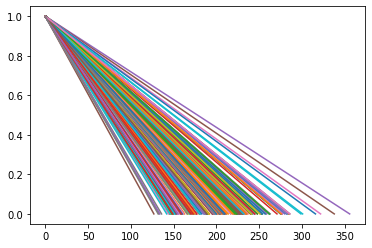

In [41]:
num_sen= len(sen)
df_train_x_final_bias_temp = df_train_x_final.drop(["unit_no","cycles"],axis=1)
df_train_x_final_bias_temp = np.array(df_train_x_final_bias_temp)
one = np.ones((df_train_x_final_bias_temp.shape[0],1))
df_train_x_final_bias = np.hstack((one,df_train_x_final_bias_temp))


Ti= [ ]
Health_Parameter= np.ndarray(shape=(0,1))

for i in range(1,219):
    ind= np.where(unit==i)[0]
    Ti.append(len(ind)) # To be used later in the testing phase
    temp= np.linspace(1, 0, len(ind), dtype=float).reshape(len(ind),1)
    plt.plot(range(len(temp)), temp)
    Health_Parameter= np.vstack((Health_Parameter,temp))


In [42]:
lm= LinearRegression()
lm.fit(df_train_x_final_bias,Health_Parameter)
print(lm.coef_)

[[ 0.         -0.02926276 -0.03121766 -0.05358223  0.00469632 -0.06692575
   0.00628747 -0.04054697 -0.03770819]]


In [55]:
import bottleneck as bn
mylist = [1, 2, 3, 4, 5, 6, 7]
N = 3
mva = bn.move_mean(mylist, window=N, min_count=1)
mva


array([1. , 1.5, 2. , 3. , 4. , 5. , 6. ])

In [56]:
import numpy as np
dataset = np.asarray([1, 2, 3, 4, 5, 6, 7])
ma = list()
window = 3
for t in range(0, len(dataset)):
    if t+window <= len(dataset):
        indices = range(t, t+window)
        ma.append(np.average(np.take(dataset, indices)))
else:
    ma = np.asarray(ma)
ma

array([2., 3., 4., 5., 6.])

In [51]:
mylist = [1, 2, 3, 4, 5, 6, 7]
N = 3
cumsum_vec = np.cumsum(np.insert(mylist, 0, 0)) 
ma_vec = (cumsum_vec[N:] - cumsum_vec[:-N]) / N

ma_vec
# window = np.ones(int(N))/float(N)
# np.convolve(mylist, window, 'same')


# cumsum, moving_aves = [0], []

# for i, x in enumerate(mylist, 1):
#     cumsum.append(cumsum[i-1] + x)
#     if i>=N:
#         moving_ave = (cumsum[i] - cumsum[i-N])/N
#         #can do stuff with moving_ave here
#         moving_aves.append(moving_ave)

array([0.33333333, 1.        , 2.        , 3.        , 4.        ,
       5.        , 6.        , 4.33333333, 2.33333333])